# Intro to `XGBoost`

### Installation

[Installation Guide](https://docs.google.com/document/d/11okl2SO9QqjMxp0enGmgCDgkUXZcHalcsA1k226PqUE/edit?usp=sharing)


### Import Libraries

In [119]:
import numpy as np
import pandas as pd

import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from pactools.grid_search import GridSearchCVProgressBar

from sklearn.metrics import accuracy_score

# classification models
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC


### Load Data

In [2]:
train_df = pd.read_csv('./data/train.csv')

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Cleaning

In [4]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
## Drop null Embarked
train_df = train_df[~train_df['Embarked'].isna()]

In [6]:
## Impute Age with 999
# only do this for decision trees!
train_df['Age'] = train_df['Age'].fillna(999)

In [7]:
## Binarize Cabin
train_df['Cabin'] = (~train_df['Cabin'].isna()).astype(int)

In [8]:
## All cleaned up
train_df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### Feature Engineering: Dummies

In [9]:
train_df = pd.get_dummies(train_df, columns = ['Sex', 'Embarked'], drop_first=True)
train_df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,1,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,1,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,0,1,0,1


In [10]:
train_df.shape

(889, 13)

### Create `X` and `y` variables

In [11]:
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 
            'Cabin', 'Sex_male', 'Embarked_Q', 'Embarked_S']

X = train_df[features]
y = train_df['Survived']

### Train Test Split

In [12]:
# remember to stratify to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                  random_state = 42,
                                                  stratify = y)

### LogisticRegression

In [24]:
logreg = LogisticRegression(random_state = 42)
cross_val_score(logreg, X, y, cv = 5).mean()

0.7874246175331683

### RandomForest

In [25]:
rf = RandomForestClassifier(random_state = 42)
cross_val_score(rf, X, y, cv = 5).mean()

0.8043102901034723

### ExtraTrees

In [26]:
et = ExtraTreesClassifier(random_state = 42)
cross_val_score(et, X, y, cv = 5).mean()

0.7885609090332

### GradientBoosting

In [27]:
gb = GradientBoostingClassifier(random_state = 42)
cross_val_score(gb, X, y, cv = 5).mean()

0.8234241096933917

### XGBoost

In [115]:
params = {'max_depth': 2, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}

num_round = 10 

dtrain = xgb.DMatrix(X_train, y_train)
xgb_model = xgb.train(params, dtrain, num_round)

dtest = xgb.DMatrix(X_test, y_test)
ypred = xgb_model.predict(dtest)

In [117]:
xgb.cv(params, dtrain)

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.189940,0.014045,0.237237,0.012916
1,0.183183,0.010457,0.240240,0.014864
2,0.160661,0.007432,0.208709,0.036285
3,0.153153,0.014712,0.210210,0.016585
4,0.147147,0.015640,0.207207,0.016854
5,0.141892,0.011484,0.216216,0.019462
6,0.137388,0.010239,0.210210,0.011823
7,0.134384,0.010128,0.205706,0.018143
8,0.130631,0.006370,0.201201,0.018143
9,0.123123,0.012517,0.195195,0.011236


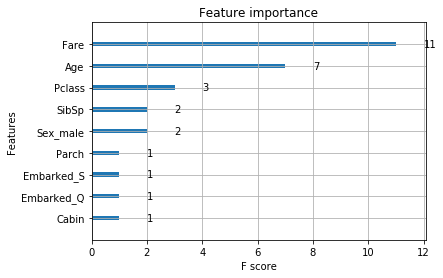

In [109]:
xgb.plot_importance(bst)

In [28]:
xgb_model = XGBClassifier(random_state = 42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print(f'{xgb_model.get_params}')
print(f'{xgb_model.score(X_test, y_test)}')

cross_val_score(xgb_model, X, y, cv = 5).mean()

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)>
0.8161434977578476


0.8279311877102774

### Grid Search

In [29]:
def gridsearch_summary(X_train, X_test, y_train, y_test, model_name, model, model_params, problem = 'classification'):
    '''
    Arguments:
    X_train, X_test, y_train, y_test : vectorized train test split of X and y
    model_name : str name of model
    model : model constructor
        example: 'LogisticRegression' : LogisticRegression()
    model_params : dictionary of param_grids for GridSearch
        example: 'LogisticRegression' : {
                      'penalty' : ['l1', 'l2'],
                      'C' : [.1, 1, 10] }
    problem : str of problem type: 'classification' or 'regression'
    
    Return:
    summary_df : a single row DataFrame containing the GridSearch model and its 
              best model, predictions, and scores.
    '''   
    problem = problem.lower()
    
    if problem != 'regression' and problem != 'classification':
        print('Invalid problem type. Try "regression" or "classification"')
        return

    summary = {}

    # Track progress
    print(f'Fitting {model_name}')

    # GridSearch
    gs = GridSearchCVProgressBar(model, model_params, cv = 5)
    gs.fit(X_train, y_train)

    # Make predictions
    y_train_pred = gs.best_estimator_.predict(X_train)
    y_test_pred = gs.best_estimator_.predict(X_test)

    # Build summary
    summary['Model Name'] = model_name
    summary['Train Pred'] = y_train_pred
    summary['Test Pred'] = y_test_pred
    summary['Best Score'] = gs.best_score_
    summary['Best Params'] = gs.best_params_
    summary['Best Estimator'] = gs.best_estimator_
    summary['Grid Search Model'] = gs

    if problem == 'regression':
        summary['Train Score'] = r2_score(y_train, y_train_pred)
        summary['Test Score'] = r2_score(y_test, y_test_pred)
    elif problem == 'classification':
        summary['Train Score'] = accuracy_score(y_train, y_train_pred)
        summary['Test Score'] = accuracy_score(y_test, y_test_pred)
    
    # Construct output dataframe 
    summary_df = pd.DataFrame([summary])

    # Rearrange columns
    summary_df = summary_df[['Model Name', 'Best Params', 'Best Score', 'Best Estimator',
                             'Train Score', 'Test Score', 'Train Pred', 'Test Pred', 'Grid Search Model']]
        
    return summary_df

### GridSearch Params

In [45]:
classifier_models = {
    'LogisticRegression' : LogisticRegression(random_state = 42),
    'KNN': KNeighborsClassifier(), 
    'NaiveBayes' : MultinomialNB(),
    'DecisionTree' : DecisionTreeClassifier(random_state = 42), 
    'BaggedDecisionTree' : BaggingClassifier(random_state = 42),
    'RandomForest' : RandomForestClassifier(random_state = 42), 
    'ExtraTrees' : ExtraTreesClassifier(random_state = 42), 
    'AdaBoost' : AdaBoostClassifier(random_state=42), 
    'GradientBoosting' : GradientBoostingClassifier(random_state = 42),
    'SVM' : SVC(random_state=42),
    'XGBoost' : XGBClassifier(random_state=42)
}

In [120]:
classifier_model_params = {
    'LogisticRegression' : {
        'penalty' : ['l1', 'l2'],
        'C' : np.arange(.05, 1, .05) },
    'KNN' : {
        'n_neighbors' : np.arange(3, 22, 2) },
    'NaiveBayes' : {
        'alpha' : np.arange(.05, 2, .05)},
    'DecisionTree': {
        'max_depth' : [None, 6, 10, 14], 
        'min_samples_leaf' : [1, 2],
        'min_samples_split': [2, 3] },
    'BaggedDecisionTree' : {
        'n_estimators' : [20, 60, 100] },
    'RandomForest' : {
        'n_estimators' : [20, 60, 100],
        'max_depth' : [None, 2, 6, 10],
        'min_samples_split' : [2, 3, 4] },
    'ExtraTrees' : {
        'n_estimators' : [20, 60, 100],
        'max_depth' : [None, 6, 10, 14],
        'min_samples_leaf' : [1, 2], 
        'min_samples_split' : [2, 3], },
    'AdaBoost' : {
        'n_estimators' : np.arange(100, 151, 25),
        'learning_rate' : np.linspace(0.05, 1, 20) },
    'GradientBoosting' : {
        'n_estimators' : np.arange(5, 150, 10),
        'learning_rate' : np.linspace(0.05, 1, 20),
        'max_depth' : [1, 2, 3] },
    'SVM' : {
        'C' : np.arange(0.05, 1, .05),
        'kernel' : ['rbf', 'linear'] },
    'XGBoost' : {
        'n_estimators'  : np.arange(100, 151, 25), 
        'learning_rate' : np.arange(0.1, 1, .3),
        'max_depth' : [3],
        'alpha' : np.arange(0, 1, .3),
        'lambda' : np.arange(0, 1, .3),
        'gamma' : np.arange(0, 1, .3),
        'subsample' : [.5],
        'n_jobs' : [4],
        }
}

In [85]:
n_combinations = np.product([len(val) for val in classifier_model_params['GradientBoosting'].values()])
print(f'Number of GradientBoosting combinations: {n_combinations}')

Number of GradientBoosting combinations: 900


In [86]:
n_combinations = np.product([len(val) for val in classifier_model_params['XGBoost'].values()])
print(f'Number of XGBoost combinations: {n_combinations}')

Number of XGBoost combinations: 576


### GradientBoosting vs. XGBoost

In [91]:
gs_summaries = pd.DataFrame()

#### Compare using the same grid search params

In [93]:
t0 = time.time()

for model in ['GradientBoosting', 'XGBoost']:
    gs_summaries = gs_summaries.append(
                        gridsearch_summary(
                            X_train, X_test, y_train, y_test, 
                            model, 
                            classifier_models[model], 
                            classifier_model_params['GradientBoosting']), 
                            ignore_index = True)
time.time() - t0

Fitting GradientBoosting
[........................................] 100% | 167.18 sec | GridSearchCV 
Fitting XGBoost
[........................................] 100% | 96.26 sec | GridSearchCV 


263.5572762489319

In [94]:
gs_summaries[['Model Name', 'Best Params', 'Best Score', 'Train Score', 'Test Score']]

,Model Name,Best Params,Best Score,Train Score,Test Score
0,GradientBoosting,"{'learning_rate': 0.2, 'max_depth': 3, 'n_esti...",0.839339,0.926426,0.816143
1,XGBoost,"{'learning_rate': 0.75, 'max_depth': 3, 'n_est...",0.836336,0.891892,0.793722


### Battle Royale

#### Re-grid search XGBoost with more parameters

In [95]:
t0 = time.time()
# gs_summaries = pd.DataFrame()

models = ['LogisticRegression', 'KNN', 'NaiveBayes', 
          'DecisionTree', 'BaggedDecisionTree', 
          'RandomForest', 'ExtraTrees', 'AdaBoost', 'SVM',
          'XGBoost']

for model in models:
    gs_summaries = gs_summaries.append(
                        gridsearch_summary(
                            X_train, X_test, y_train, y_test, 
                            model, classifier_models[model], 
                            classifier_model_params[model]), 
                            ignore_index = True)
time.time() - t0

Fitting LogisticRegression
[........................................] 100% | 1.43 sec | GridSearchCV 
Fitting KNN
[........................................] 100% | 1.33 sec | GridSearchCV 
Fitting NaiveBayes
[........................................] 100% | 1.16 sec | GridSearchCV 
Fitting DecisionTree
[........................................] 100% | 0.54 sec | GridSearchCV 
Fitting BaggedDecisionTree
[........................................] 100% | 1.33 sec | GridSearchCV 
Fitting RandomForest
[........................................] 100% | 12.75 sec | GridSearchCV 
Fitting ExtraTrees
[........................................] 100% | 17.78 sec | GridSearchCV 
Fitting AdaBoost
[........................................] 100% | 47.09 sec | GridSearchCV 
Fitting SVM
[........................................] 100% | 37.77 sec | GridSearchCV 
Fitting XGBoost
[........................................] 100% | 209.62 sec | GridSearchCV 


334.12245297431946

In [121]:
model = 'SVM'
gs_summaries = gs_summaries.append(
                        gridsearch_summary(
                            X_train, X_test, y_train, y_test, 
                            model, 
                            classifier_models[model], 
                            classifier_model_params[model]), 
                            ignore_index = True)

Fitting SVM
[........................................] 100% | 262.74 sec | GridSearchCV 


In [122]:
gs_summaries[['Model Name', 'Best Params', 'Best Score', 'Train Score', 'Test Score']].sort_values(by = 'Best Score')

,Model Name,Best Params,Best Score,Train Score,Test Score
4,NaiveBayes,{'alpha': 0.05},0.501502,0.498498,0.479821
3,KNN,{'n_neighbors': 15},0.719219,0.752252,0.686099
10,SVM,"{'C': 0.1, 'kernel': 'linear'}",0.794294,0.794294,0.762332
12,SVM,"{'C': 0.05, 'kernel': 'linear'}",0.794294,0.794294,0.762332
2,LogisticRegression,"{'C': 0.1, 'penalty': 'l2'}",0.797297,0.798799,0.784753
6,BaggedDecisionTree,{'n_estimators': 100},0.810811,0.987988,0.802691
5,DecisionTree,"{'max_depth': 6, 'min_samples_leaf': 1, 'min_s...",0.815315,0.878378,0.766816
8,ExtraTrees,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.815315,0.935435,0.775785
9,AdaBoost,"{'learning_rate': 1.0, 'n_estimators': 150}",0.815315,0.861862,0.811659
7,RandomForest,"{'max_depth': 10, 'min_samples_split': 4, 'n_e...",0.825826,0.933934,0.798206


In [96]:
gs_summaries[['Model Name', 'Best Params', 'Best Score', 'Train Score', 'Test Score']].sort_values(by = 'Best Score')

,Model Name,Best Params,Best Score,Train Score,Test Score
4,NaiveBayes,{'alpha': 0.05},0.501502,0.498498,0.479821
3,KNN,{'n_neighbors': 15},0.719219,0.752252,0.686099
10,SVM,"{'C': 0.1, 'kernel': 'linear'}",0.794294,0.794294,0.762332
2,LogisticRegression,"{'C': 0.1, 'penalty': 'l2'}",0.797297,0.798799,0.784753
6,BaggedDecisionTree,{'n_estimators': 100},0.810811,0.987988,0.802691
5,DecisionTree,"{'max_depth': 6, 'min_samples_leaf': 1, 'min_s...",0.815315,0.878378,0.766816
8,ExtraTrees,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.815315,0.935435,0.775785
9,AdaBoost,"{'learning_rate': 1.0, 'n_estimators': 150}",0.815315,0.861862,0.811659
7,RandomForest,"{'max_depth': 10, 'min_samples_split': 4, 'n_e...",0.825826,0.933934,0.798206
11,XGBoost,"{'alpha': 0.0, 'gamma': 0.0, 'lambda': 0.0, 'l...",0.833333,0.885886,0.816143


### Conclusions

The dataset may be too small to stress test the accuracy and computational speed of XGBoost.

XGBoost has more hyperparameters to tune, so it may end up being better after tweaking them more.